In [19]:
!pip install torch torchvision transformers faiss-cpu



In [20]:
import torch
from torchvision import models, transforms
from PIL import Image
image_path = "/content/Screenshot 2024-09-05 at 7.59.37 PM.png"
def extract_image_features(image_path):
    model = models.resnet50(pretrained=True)
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda image: image[:3, :, :]),  # Select first 3 channels (RGB)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB') # Convert image to RGB
    image_tensor = preprocess(image).unsqueeze(0)

    with torch.no_grad():
        features = model(image_tensor)

    return features


In [21]:
import faiss
import numpy as np

def create_faiss_index(text_embeddings):
    dimension = text_embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(text_embeddings)
    return index

def retrieve_related_text(index, query_embedding, k=5):
    distances, indices = index.search(query_embedding, k)
    return indices


In [22]:
from transformers import CLIPProcessor, CLIPModel

def integrate_features_with_text(image_features, text_indices, text_data):
    # Example: You might concatenate or otherwise combine features here.
    # This is a placeholder function for integration.
    integrated_features = image_features
    for index in text_indices:
        integrated_features = torch.cat((integrated_features, text_data[index]), dim=1)
    return integrated_features


In [23]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

def generate_summary(integrated_features):
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small")

    # Convert features to text (requires additional steps for a real scenario)
    input_text = "Generate a summary for the following content."

    inputs = tokenizer(input_text, return_tensors="pt")
    outputs = model.generate(inputs["input_ids"], max_length=150)

    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary


In [24]:
def mm_rag_pipeline(image_path, text_data, text_embeddings):
    # Extract features from the image
    image_features = extract_image_features(image_path)

    # Create and use FAISS index
    index = create_faiss_index(text_embeddings)
    query_embedding = image_features.numpy()
    text_indices = retrieve_related_text(index, query_embedding)

    # Integrate image features with retrieved text
    integrated_features = integrate_features_with_text(image_features, text_indices, text_data)

    # Generate summary
    summary = generate_summary(integrated_features)
    return summary

# Example usage
text_data = [...]  # List of text documents
text_embeddings = np.array([...])  # Embeddings of the text documents
summary = mm_rag_pipeline(image_path, text_data, text_embeddings)
print(summary)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


IndexError: tuple index out of range

In [25]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

def test_image_summarization(image_path):
    # Load BLIP model and processor
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    # Open and preprocess the image
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")

    # Generate summary
    outputs = model.generate(**inputs)
    summary = processor.decode(outputs[0], skip_special_tokens=True)

    return summary

# Example usage
summary = test_image_summarization(image_path)
print("Generated Summary:", summary)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated Summary: a group of people playing baseball on a beach


In [26]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

def generate_text_with_blip2(image_path):
    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")

    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")

    outputs = model.generate(**inputs)
    summary = processor.decode(outputs[0], skip_special_tokens=True)

    return summary

In [27]:
generate_text_with_blip2(image_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

'gandhi walking on the beach with his family\n'

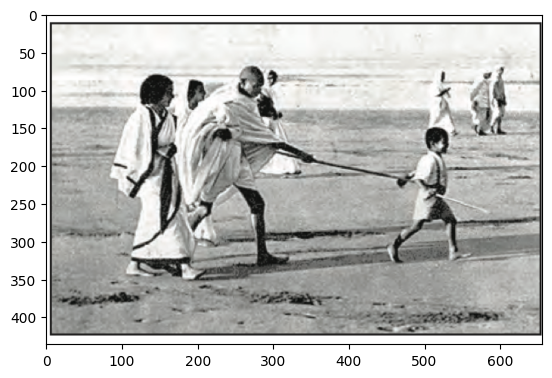

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)

In [29]:
generate_text_with_blip2("/content/Screenshot 2024-09-05 at 7.59.54 PM.png")
#

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

'a diagram of a particle at a point\n'